In [62]:
#import files needed

import torch
import torch.nn as nn
from torch import Tensor

import numpy as np
import xarray as xr
import scipy as sp
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.units import units

In [63]:
"""
data file: florence_2018
    values:

        u10: 10m u wind component
            wind_value
        v10: 10m v wind component
        sst: sea surface temperature 
"""
data = xr.open_dataset('./data/florence_2018.nc')

In [64]:
##data extraction from the netcdf file
u_wind_da = data['u10']
v_wind_da = data['v10']
lon = data['longitude']
lat = data['latitude']

##calculating wind speed for plotting
u_wind = u_wind_da.values * units('m/s')
v_wind = v_wind_da.values * units('m/s')

##values below this line
u_wind = u_wind_da.values
v_wind = v_wind_da.values
u_wind_tensor = torch.from_numpy(u_wind)
v_wind_tensor = torch.from_numpy(v_wind)

In [65]:
##You can only get the lat and lon metadata from the original xarray data 

##u wind lat and long data
lat_u = u_wind_da.coords['latitude'].values
lon_u = u_wind_da.coords['longitude'].values

##v wind lat and lon data
lat_v = v_wind_da.coords['latitude'].values
lon_v = v_wind_da.coords['longitude'].values

In [66]:
#print(u_wind_tensor)
##function to normalize the data between 0-1 in order to give a normal distribution which will be easier for the model
## to interperate
tensor = Tensor

def normalize(x: tensor) -> Tensor:
    tensor = x
    valid_mask = ~torch.isnan(tensor) ## the ~ creates a boolean mask to show true if there is a non-nan value
    valid_tensor = tensor[valid_mask]

    min_val = valid_tensor.min()
    max_val = valid_tensor.max()

    normalized_tensor = (0.1 * (max_val - tensor) + 0.9 * (tensor - min_val)) / (max_val - min_val)
    return normalized_tensor

#normalizing the data
normal_u = normalize(u_wind_tensor).unsqueeze(0)
normal_v = normalize(v_wind_tensor).unsqueeze(0)


In [67]:
print(normal_u)

tensor([[[[0.4779, 0.4798, 0.4814,  ..., 0.5899, 0.5842, 0.5758],
          [0.4796, 0.4794, 0.4805,  ..., 0.5925, 0.5880, 0.5794],
          [0.4793, 0.4800, 0.4806,  ..., 0.5949, 0.5904, 0.5818],
          ...,
          [0.5326, 0.5311, 0.5302,  ..., 0.5929, 0.5945, 0.5950],
          [0.5230, 0.5275, 0.5323,  ..., 0.5946, 0.5945, 0.5960],
          [0.5206, 0.5248, 0.5292,  ..., 0.5932, 0.5958, 0.5969]],

         [[0.4889, 0.4922, 0.4919,  ..., 0.5994, 0.5999, 0.6009],
          [0.4890, 0.4910, 0.4911,  ..., 0.5972, 0.5990, 0.6002],
          [0.4915, 0.4904, 0.4896,  ..., 0.5956, 0.5976, 0.5994],
          ...,
          [0.5375, 0.5423, 0.5452,  ..., 0.5803, 0.5778, 0.5757],
          [0.5204, 0.5251, 0.5321,  ..., 0.5852, 0.5822, 0.5811],
          [0.5141, 0.5145, 0.5219,  ..., 0.5860, 0.5859, 0.5845]],

         [[0.4932, 0.4953, 0.5001,  ..., 0.6012, 0.5931, 0.5853],
          [0.4926, 0.4941, 0.5012,  ..., 0.5934, 0.5869, 0.5791],
          [0.4961, 0.4992, 0.5035,  ..., 0

In [68]:
#print(normal_v)
print(normal_u.shape)
print(normal_v.shape)

torch.Size([1, 32, 141, 281])
torch.Size([1, 32, 141, 281])


In [69]:
## simple testing classes to see how the operations transformed the data

class Conv_Wind(nn.Module):
    def __init__(self, in_feat, out_feat, kernel_size=2):
        super(Conv_Wind,self).__init__()
        self.conv_2d = nn.Conv2d(in_feat, out_feat, kernel_size)
    
    def forward(self, x):
        return self.conv_2d(x)
    
class MaxPool_Wind(nn.Module):
    def __init__(self):
        super(MaxPool_Wind, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        return self.maxpool(x)
    
class AvgPool_Wind(nn.Module):
    def __init__(self):
        super(AvgPool_Wind, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        return self.avgpool(x)

In [70]:
conv = Conv_Wind(in_feat=32, out_feat=32, kernel_size=2)
conv_output = conv(normal_u)

maxpool = MaxPool_Wind()
max_output = maxpool(normal_u)

avgpool = AvgPool_Wind()
avg_output = avgpool(normal_u)

In [71]:
print(conv_output)

tensor([[[[ 0.2277,  0.2263,  0.2238,  ...,  0.2121,  0.2122,  0.2111],
          [ 0.2247,  0.2234,  0.2211,  ...,  0.2233,  0.2222,  0.2210],
          [ 0.2231,  0.2200,  0.2194,  ...,  0.2320,  0.2301,  0.2277],
          ...,
          [ 0.2361,  0.2319,  0.2286,  ...,  0.2487,  0.2497,  0.2547],
          [ 0.2414,  0.2379,  0.2334,  ...,  0.2505,  0.2513,  0.2549],
          [ 0.2350,  0.2358,  0.2383,  ...,  0.2506,  0.2515,  0.2516]],

         [[-0.4604, -0.4614, -0.4607,  ..., -0.4701, -0.4745, -0.4737],
          [-0.4607, -0.4602, -0.4578,  ..., -0.4754, -0.4795, -0.4803],
          [-0.4584, -0.4559, -0.4539,  ..., -0.4806, -0.4822, -0.4836],
          ...,
          [-0.4695, -0.4707, -0.4684,  ..., -0.4980, -0.4991, -0.5005],
          [-0.4717, -0.4678, -0.4652,  ..., -0.4998, -0.5000, -0.4998],
          [-0.4701, -0.4686, -0.4662,  ..., -0.5014, -0.5036, -0.5005]],

         [[-0.2027, -0.1987, -0.1966,  ..., -0.2619, -0.2633, -0.2631],
          [-0.2033, -0.1993, -

In [72]:
conv_output = torch.squeeze(conv_output, dim=0)
conv_output.shape

torch.Size([32, 140, 280])

Saved wind_speed_coolmap.gif


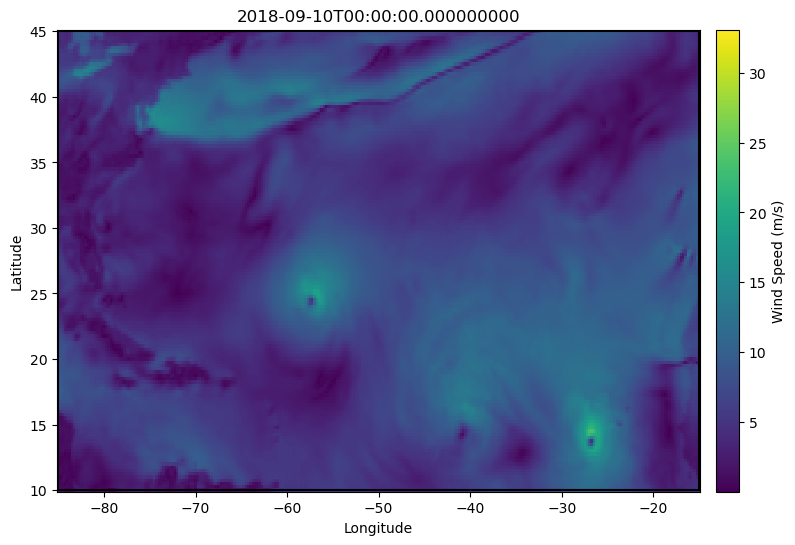

In [73]:
from matplotlib.animation import FuncAnimation, PillowWriter

## loading data
ds = xr.open_dataset('./data/florence_2018.nc')
u = ds['u10'].values   ## (time, lat, lon)
v = ds['v10'].values
times = ds['valid_time'].values
lats = ds['latitude'].values
lons = ds['longitude'].values

## wind speed
speed = np.sqrt(u**2 + v**2)

## creating grid
lon2d, lat2d = np.meshgrid(lons, lats)

## preparing the graph
fig, ax = plt.subplots(figsize=(10, 6))

## adding coastlines within plot to show where storm flows from data
try:
    ds.coastlines(resolution='50m').plot(ax=ax, color='k')
except Exception:
    ## makes visualization the max and min of lat and lons
    ax.plot([lons.min(), lons.max()], [lats.min(), lats.min()], 'k-')
    ax.plot([lons.min(), lons.max()], [lats.max(), lats.max()], 'k-')
    ax.plot([lons.min(), lons.min()], [lats.min(), lats.max()], 'k-')
    ax.plot([lons.max(), lons.max()], [lats.min(), lats.max()], 'k-')

im = ax.pcolormesh(
    lon2d, lat2d, speed[0],
    cmap='viridis', shading='auto',
    vmin=np.nanmin(speed), vmax=np.nanmax(speed)
)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Wind Speed (m/s)')

title = ax.set_title(str(times[0]))

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

## updating the animation
def update(frame):
    im.set_array(speed[frame].ravel())
    title.set_text(str(times[frame]))
    return im, title

anim = FuncAnimation(fig, update, frames=len(times), interval=200)

anim.save('wind_speed_coolmap.gif', writer=PillowWriter(fps=5))
print("Saved wind_speed_coolmap.gif")
